# Entertainment Category: HuggingFace

# Setting Up Necessary Things

In [1]:
# Jupyter Notebook Magic Command - Auto Reloading
%reload_ext autoreload
%autoreload 2

# Jupyter Notebook Magic Command - Inline Plotting
%matplotlib inline

In [2]:
# Ignore All Warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Check GPU Status
!nvidia-smi

Mon Sep 11 22:30:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

# Necessary Imports

In [ ]:
! pip install -q transformers[sentencepiece] fastai ohmeow-blurr

In [5]:
import torch

from transformers import AutoModelForSequenceClassification, AutoConfig

from fastai.text.all import *

from blurr.text.data.all import *
from blurr.text.modeling.all import *

In [6]:
# Check Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Data Cleaning

In [13]:
# Path
file_path = "/kaggle/input/ec-dataset/entertainment_category.csv"

In [14]:
# Show Anime DataFrame
df = pd.read_csv(file_path)
df.head()

,description,category
0,"What could be worse than letting billions die? In the near future, to escape the crush and clutter of a packed and polluted Earth, the world's elite flock to Atopia, an enormous corporate-owned artificial island in the Pacific Ocean. It is there that Dr. Patricia Killiam rushes to perfect the ultimate in virtual reality: a program to save the ravaged Earth from mankind's insatiable appetite for natural resources. The Atopia Chronicles (Book 1 of the Atopia series) is the tale of mankind's dark slide across the apocalypse as humans and machines merge in a world teetering on the brink of eco...",book
1,"Jorge Luis Borges declared The Invention of Morel a masterpiece of plotting, comparable to The Turn of the Screw and Journey to the Center of the Earth. Set on a mysterious island, Bioy's novella is a story of suspense and exploration, as well as a wonderfully unlikely romance, in which every detail is at once crystal clear and deeply mysterious. Inspired by Bioy Casares's fascination with the movie star Louise Brooks, The Invention of Morel has gone on to live a secret life of its own. Greatly admired by Julio Cortázar, Gabriel García Márquez, and Octavio Paz, the novella helped to usher ...",book
2,"Thee devil shall roam the earth And plague and terror shall reign Upon the world of man Heaven shattered Destruction of angels shall commence From his mighty seat the great one shall be cast down Impaled and defiled, his throne upon the pyre Inflamed with the seeds of misery The immortal blood will be spilt And the dark underworld will be unleashed A feeble prayer to failing deities To the ancient evil nothing is sacred A once powerful ruler, now a helpless whelp Bowing down before the eternal demon Roots rising From the dank earth piercing through the Savior's skin upwards from the pit of...",music
3,"(Hook) Them niggas over there, never play fair You cud get hit wit that stick They do not care You a fruity nigga, you a care bear We running wit static We splitting yo cabbage We dug u a hole We lessen your baggage You luggage in the attic I put that on a Patek Am i bout this shit nigga Oui Oui Oui Oui Oui Ey! (Verse 1) Them niggas that hate They asking dem questions They looking so clueless And then they debate But those who the realest They movin immune They fresh like Colgate We smoke us a pack We plan an/and attack We never back down We tossing to/the die And thats for a fact Money wa...",music
4,"Jigsaw Puzzle: Beach Season – the journey to the seaside starts right now! 500 high-quality photos means 500 ideas for a summer vacation! Take a virtual tour of the resorts of your dreams: Hawaii, Bali, the Maldives, Seychelles, the Caribbean… Enjoy exotic photos of these little corners of paradise on our planet. Romantic views, golden beaches, unique nature and incredible local cuisine. Jigsaw Puzzle: Beach Season will tell you where to find the best places on our planet for a calm and relaxing vacation and where adventure-seekers can go for some active rest. See local flora and fauna, ex...",game


In [15]:
df.shape

(42535, 2)

In [16]:
df.isna().sum()

description    0
category       0
dtype: int64

In [17]:
df.dtypes

description    object
category       object
dtype: object

In [18]:
df["category"].value_counts()

category
movie      8676
anime      8630
game       8541
book       7574
music      5644
tv show    3470
Name: count, dtype: int64

In [19]:
labels = list(set(df["category"].to_list()))
labels_count = len(labels)
labels_count, labels

(6, ['movie', 'music', 'tv show', 'game', 'book', 'anime'])

## Data-Loaders and Model Setup

### Model Setup

In [20]:
model_name = "distilroberta-base"
model_cls = AutoModelForSequenceClassification

In [21]:
config = AutoConfig.from_pretrained(model_name)
config.num_labels = labels_count

In [22]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(model_name, model_cls=model_cls, config=config)

### Data-Loaders

In [23]:
blocks = (TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), CategoryBlock)
dblock = DataBlock(blocks=blocks, get_x=ColReader("description"), get_y=ColReader("category"), splitter=RandomSplitter(valid_pct=0.1, seed=42))

In [24]:
dls = dblock.dataloaders(df, bs=32)
torch.save(dls, "/kaggle/working/dls-entertainment-category.pkl")

In [25]:
dls.show_batch(dataloaders=dls, max_n=3, trunc_at=500)

,text,target
0,"567 U.S. 701 (2007)Chief Justice ROBERTS announced the judgment of the Court,and delivered the opinion of the Court with respect to Parts I, II, III-A, and III-C, and an opinion with respect to Parts III-B and IV, in which Justices SCALIA, THOMAS, and ALITO join. The school districts in these cases voluntarily adopted student assignment plans that rely upon race to determine which public schools certain children may attend. The Seattle school district classifies children as white or nonwhite; t",music
1,"A Pleasant Day With An Unpleasant Termination The birds, who, happily for their own peace of mind and personal comfort, were in blissful ignorance of the preparations which had been making to astonish them, on the first of September, hailed it, no doubt, as one of the pleasantest mornings they had seen that season. Many a young partridge who strutted complacently among the stubble, with all the finicking coxcombry of youth, and many an older one who watched his levity out of his little round ey",music
2,"THE Forest of Brécéliande, in Brittany, the scene of the leading incident in the Chevalier au Lion, has ever been one of the most favoured haunts of Romance, and one whose marvels the Trouvères have most delighted to celebrate. Amongst those whose names have contributed to add to the renown of this remarkable spot, is the mighty Enchanter, Merlin, whose prison it became through the artifices of his Lady love. The manner of his being incarcerated there is very circumstantially detailed in the Ro",music


### Model

In [26]:
model = BaseModelWrapper(hf_model)

learner = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.AdamW),
    loss_func=PreCalculatedCrossEntropyLoss(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter
).to_fp16()

In [27]:
learner.model

BaseModelWrapper(
  (hf_model): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Li

# Model Training

## Stage - 0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


SuggestedLRs(minimum=5.754399462603033e-05, steep=0.00010964782268274575)

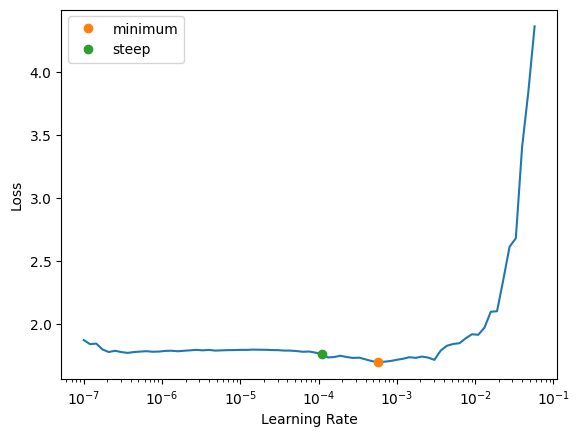

In [28]:
learner.lr_find(suggest_funcs=[minimum, steep])

In [29]:
learner.fit_one_cycle(1, 8.25e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.208515,0.170552,0.940748,04:54


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you

In [30]:
learner.save("entertainment-category-stage-0")

Path('models/entertainment-category-stage-0.pth')

## Stage - 1

In [34]:
learner.unfreeze()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


SuggestedLRs(slide=0.00015848931798245758, valley=2.511886486900039e-05)

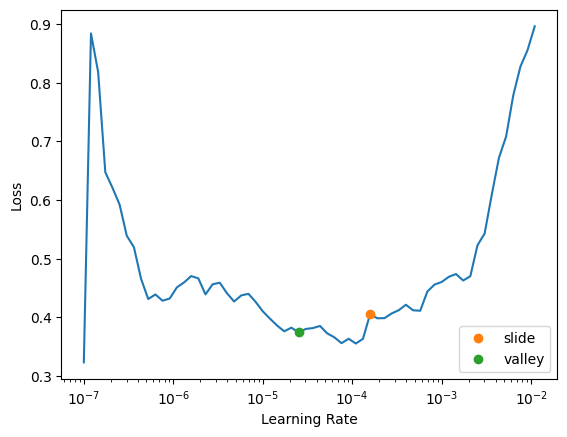

In [35]:
learner.lr_find(suggest_funcs=[slide, valley])

In [36]:
learner.fit_one_cycle(5, slice(1.25e-4, 2.75e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.183650,0.197449,0.933929,04:55
1,0.139328,0.219831,0.936280,04:56
2,0.082482,0.195504,0.942158,04:55
3,0.028951,0.255362,0.940983,04:44
4,0.009235,0.269965,0.940513,04:28


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [37]:
learner.save("entertainment-category-stage-1")

Path('models/entertainment-category-stage-1.pth')

In [38]:
learner.export("models/entertainment-category-stage-1.pkl")